<a href="https://colab.research.google.com/github/FlavienKiefer/master_class_RV_2022/blob/main/rv_hands_on_PSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing radial velocity timeseries
## Based on DACE - python APIs
## Original author
Jean-Baptiste Delisle (DACE data scientist)

## Modified by
Flavien Kiefer and Johan Mazoyer (LESIA)

## Goals
0. Familiarize with stellar spectra, CCF and RV,
1. Use DACE APIs to download radial velocity timeseries
2. Visualize and analyze it (periodograms, fit, MCMC, etc.)

## Topics
0. Packages installation with **pip install**
1. Downloading shifted stellar spectra from GitHub 
2. Calculating CCF and determining RVs
3. Downloading radial velocity timeseries using DACE APIs
4. Defining a model
5. Looking for planetary signals using a periodogram (+ FAP) approach
5. Fitting model parameters
6. Launching an MCMC (samsam)

## Requirements
python 3, matplotlib, numpy, scipy, astroquery  
**python-dace-client, kepmodel, samsam, corner** (see below for installation instructions)

## Packages installation

**Clone GitHub** from https://github.com/FlavienKiefer/master_class_RV_2022.git

**Install DACE APIs** (see also [DACE APIs installation tutorial](https://dace.unige.ch/tutorials/?tutorialId=10)):  
`pip install python-dace-client`

**Install kepmodel**:  
`pip install --extra-index-url https://obswww.unige.ch/~delisle kepmodel`

**Install samsam**:  
`pip install --extra-index-url https://obswww.unige.ch/~delisle samsam`

**Install corner**:  
`pip install corner`

In [ ]:
%cd /content/
!git config --global user.name FlavienKiefer
!git clone https://github.com/FlavienKiefer/master_class_RV_2022.git master_class_RV_2022 # temp
# !rm -rf master_class_RV_2022/*
# !rsync -a temp/* master_class_RV_2022/.
# !rm -rf temp

/content
Cloning into 'temp'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 164 (delta 26), reused 154 (delta 16), pack-reused 0
Receiving objects: 100% (164/164), 8.42 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
%cd /content/master_class_RV_2022/

/content/master_class_RV_2022


## Imports

In [ ]:
%%capture
!pip install astropy
!pip install numpy
!pip install scipy
!pip install pandas
!pip install matplotlib
!pip install astroquery
!pip install corner
!pip install pandas
!pip install python-dace-client
!pip install --extra-index-url https://obswww.unige.ch/~delisle kepmodel
!pip install --extra-index-url https://obswww.unige.ch/~delisle samsam

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from dace.spectroscopy import Spectroscopy
from astroquery.simbad import Simbad
from kepmodel import rv, tools
from spleaf import term
from samsam import sam, logprior, acf
import corner
from rvmodel import *

# Part 1 : Determine the radial velocity of the star with the Cross Correlation Function (CCF)

In [ ]:
c = 2.99792e5
 
# wavelengths shifts can be converted to delta velocities using doppler formula
def wav_to_dvel(wav):
    dvel = (wav[1:] - wav[:-1]) / (wav[1:]) * c
    return dvel

# Load the series of spectra

In [ ]:
series = []
file_list = sorted(glob('synthetic_spectra/*.csv'))
for f in file_list:
    print(f)
    spec = pd.read_csv(f)
    series.append(spec)

synthetic_spectra/5800K+00.csv
synthetic_spectra/5800K+05.csv
synthetic_spectra/5800K+10.csv
synthetic_spectra/5800K+15.csv
synthetic_spectra/5800K+20.csv
synthetic_spectra/5800K-05.csv
synthetic_spectra/5800K-10.csv
synthetic_spectra/5800K-15.csv
synthetic_spectra/5800K-20.csv


Plot a synthetic spectrum vs wavelength (expressed in Angstrom)

Text(0, 0.5, 'Flux [ADU]')

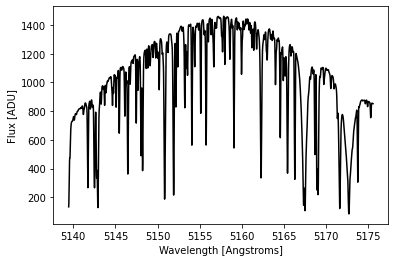

In [ ]:
sp = series[0]
plt.plot(sp['wavelength'], sp['flux'], 'k-')
plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [ADU]')

Compare two spectra with different Doppler shift

(5150.0, 5155.0)

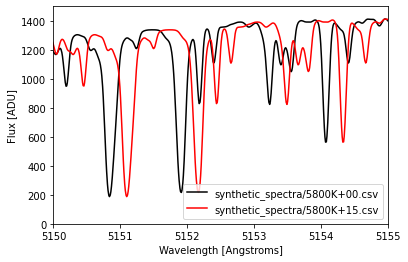

In [ ]:
spec_id1 = 0
spec_id2 = 3

spec1 = series[spec_id1]
spec2 = series[spec_id2]

plt.plot(spec1['wavelength'], spec1['flux'], 'k-', label = file_list[spec_id1])
plt.plot(spec2['wavelength'], spec2['flux'], 'r-', label = file_list[spec_id2])

plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [ADU]')
plt.legend()

plt.ylim(0,1500)
plt.xlim(5150, 5155)

# Cross Correlation Fonction

1.   Define a reference spectrum (here this is number 0)
2.   Transform wavelength to Log(wavelength) \\
$d \log \lambda = \frac{d \lambda}{\lambda} = \frac{v}{c}$ \\
Linear in $\log\lambda$ <=> Linear in $v$

3.   Calculate the cross-correlation function (CCF) \\
$f * g (t) = \int f(x-t)  g(x) \, dx$ \\
if for simplicity $g(x)=e^{-(x-x_0)^2/2}$ and $f(x)=e^{-x^2/2}$ (i.e. $g$ is the shift of $f$ by $x_0$) \\
then $f * g (t) = e^{-(t-x_0)^2/4}$ :
the CCF is a Gaussian centered at the shift $x_0$.


In [ ]:
spec_id1=0 #reference spectrum
spec_id2=3 #shifted spectrum

model = series[spec_id1] 
ref_flux = model['flux'].values
ref_wav = model['wavelength'].values

spectrum = series[spec_id2] #star spectrum
flux = spectrum['flux'].values
wav = spectrum['wavelength'].values

nwav = wav.size

# Convert target and model spectra to constant log-lambda scale
wav, flux, dvel = rvModel.loglambda(wav, flux,c)

# Perform CCF between two spectra and convert RV to wavelength shifts
dv, corr = rvModel.CCF(flux, ref_flux, nwav, dvel,ref_wav,wav)
dlambda, imax = rvModel.dlamb(corr, dv, c)

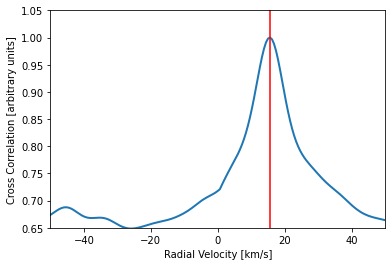

Radial velocity = 15.586742418239343 km/s


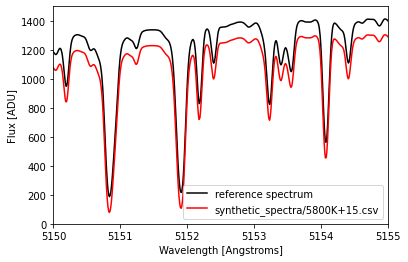

In [ ]:
# Plot of the cross correlation
plt.plot(dv, corr, lw=2)
plt.plot([dv[imax],dv[imax]],plt.gca().get_ylim(),'-r')
plt.xlim(-50, 50)
plt.ylim(0.65, 1.05)
plt.xlabel('Radial Velocity [km/s]')
plt.ylabel('Cross Correlation [arbitrary units]')
plt.show()
plt.close()

print("Radial velocity =",dv[imax],"km/s")

spec1 = series[spec_id1]
spec2 = series[spec_id2]
plt.plot(spec1['wavelength'], spec1['flux'], 'k-', label = "reference spectrum")
plt.plot(spec2['wavelength']-(dlambda), spec2['flux']-0.1*spec2['flux'].median(), 'r-', label = file_list[spec_id2])

plt.xlim(5150, 5155)
plt.ylim(0,1500)

plt.xlabel('Wavelength [Angstroms]')
plt.ylabel('Flux [ADU]')
plt.legend()

# Part 2 : Radial velocity data processing

## Settings

In [ ]:
# Data settings
target = '51 Peg'

# Instruments
instruments = [] # By default select all available instruments
inst_sec_acc = {} # Keep default settings for secular correction for each instrument
inst_jitter = {} # Keep default settings for instruments jitter
epoch_rjd = 55500

# drift power
dpow = 0

# Detrending
indicators = ['fwhm']
indic_kernel_smoother = [tools.gaussian_kernel]
indic_filter_timescale_yr = [0.5]
indic_filter_type = ['low']

# Periodogram settings
Pmin = 1.1
Pmax = 10000
nfreq = 100000
nu0 = 2 * np.pi / Pmax
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)

# Planet detection settings
fap_max = 1e-3
max_pla = 5

# Fit options
# WARNING: the fit algorithm has not been extensively tested.
# There is room for improvements
# (better choice of minimization algorithm and/or options, ...)
fit_method = 'L-BFGS-B'
fit_options = {
    'maxiter': 1000,
    'maxcor': 50
}
start_fit_jitter_at_step = 0
fit_ecc = True

# MCMC options
nsamples = 10000

## Load data

In [ ]:
# Download data
rv_data = Spectroscopy.get_timeseries(target, sorted_by_instrument=False)
nt = len(rv_data['rjd'])
# Convert to numpy arrays
for key in rv_data:
    try:
        if key == 'drs_qc':
            rv_data[key] = np.array(rv_data[key], dtype=bool)
        else:
            rv_data[key] = np.array(rv_data[key], dtype=float)
    except:
        rv_data[key] = np.array(rv_data[key])
        pass
print('Number of points before cleaning:', nt)

# DRS quality check + nans
for key in rv_data:
    if rv_data[key].dtype == float:
        rv_data[key][rv_data[key]==-99999] = np.nan
keep_crit = rv_data['drs_qc']
for key in ['rv', 'rv_err'] + indicators:
    keep_crit &= (np.array([rr==rr for rr in rv_data[key]]))
# Instruments
if instruments:
    in_inst_list = False
    for inst in instruments:
        in_inst_list = in_inst_list | (rv_data['ins_name'] == inst)
    keep_crit = keep_crit & in_inst_list
# Apply filtering
for key in rv_data:
    if len(rv_data[key]) == nt:
        rv_data[key] = rv_data[key][keep_crit]

# Remove empty instruments
instruments = np.unique(rv_data['ins_name'])
ninst = len(instruments)

# Sort by increasing time
ksort = np.argsort(rv_data['rjd'])
for key in rv_data:
    rv_data[key] = rv_data[key][ksort]

nt = rv_data['rjd'].size
print('Number of points after cleaning:', nt)
print('\nList of instruments kept after cleaning:')
print(instruments)
print('\nList of available fields:')
print(rv_data.keys())

Number of points before cleaning: 731
Number of points after cleaning: 165

List of instruments kept after cleaning:
['ELODIE']

List of available fields:
dict_keys(['caindex', 'caindex_err', 'protm08', 'protm08_err', 'berv', 'berv_err', 'drift_noise', 'drift_noise_err', 'bispan', 'bispan_err', 'texp', 'texp_err', 'fwhm', 'fwhm_err', 'cal_therror', 'cal_therror_err', 'ins_mode', 'rjd', 'rjd_err', 'rv', 'rv_err', 'ccf_noise', 'ccf_noise_err', 'rhk', 'rhk_err', 'ins_name', 'mask', 'naindex', 'naindex_err', 'snca2', 'snca2_err', 'pub_reference', 'pub_bibcode', 'contrast', 'contrast_err', 'cal_thfile', 'spectroFluxSn50', 'spectroFluxSn50_err', 'sindex', 'sindex_err', 'drs_qc', 'haindex', 'haindex_err', 'protn84', 'protn84_err', 'drs_version', 'public', 'spectroFluxSn20', 'spectroFluxSn20_err', 'drift_used', 'drift_used_err', 'ccf_asym', 'ccf_asym_err', 'date_night', 'raw_file'])


## Secular correction

In [ ]:
default_inst_sec_acc = {
  'CORALIE98': True,
  'CORALIE07': True,
  'CORALIE14': True,
  'CORAVEL': True,
  'HARPS03': True,
  'HARPS15': True,
  'HARPN': True,
  'HIRES': False,
  'UCLES': False,
  'ESPRESSO': True,
  'SOPHIE': True,
  'ELODIE': True,
  'default': False
}

# Query Simbad for parallax and proper motion
simb = Simbad()
simb.reset_votable_fields()
simb.add_votable_fields('plx', 'pmra', 'pmdec')
target_info = simb.query_object(target)
plx_mas = target_info['PLX_VALUE'] # 28.497400
pmra_mas_yr = target_info['PMRA'] # -27.951
pmdec_mas_yr = target_info['PMDEC'] # -160.436

# Compute secular acceleration
d_m = 1000.0 / plx_mas * 3.08567758e16
mu_rad_s = np.sqrt(pmra_mas_yr * pmra_mas_yr + pmdec_mas_yr *
    pmdec_mas_yr) * 2 * np.pi / (360.0 * 1000.0 * 3600.0 * 86400.0 * 365.25)
secacc = d_m * mu_rad_s * mu_rad_s * 86400.0
for inst in instruments:
    if inst in inst_sec_acc:
        apply_sec = inst_sec_acc[inst]
    elif inst in default_inst_sec_acc:
        apply_sec = default_inst_sec_acc[inst]
    else:
        apply_sec = default_inst_sec_acc['default']
    if apply_sec:
        kinst = rv_data['ins_name']==inst
        rv_data['rv'][kinst] -= (rv_data['rjd'][kinst] - epoch_rjd) * secacc

## Initialize model

In [ ]:
default_inst_jitter = {
  'CORALIE98': 5.0,
  'CORALIE07': 8.0,
  'CORALIE14': 3.0,
  'CORAVEL': 150.0,
  'HARPS03': 0.75,
  'HARPS15': 0.75,
  'HARPN': 0.75,
  'HIRES': 2.5,
  'UCLES': 7.0,
  'ESPRESSO': 0.05,
  'SOPHIE': 1.5,
  'ELODIE': 12.0,
  'default': 0.0
}

instjit = {}
for inst in instruments:
    if inst in inst_jitter:
        sig = inst_jitter[inst]
    elif inst in default_inst_jitter:
        sig = default_inst_jitter[inst]
    else:
        sig = default_inst_jitter['default']
    instjit[f'inst_jit_{inst}'] = term.InstrumentJitter(rv_data['ins_name']==inst, sig)

rv_model = rv.RvModel(
    rv_data['rjd']-epoch_rjd,
    rv_data['rv'],
    err = term.Error(rv_data['rv_err']),
    **instjit)

## Plot timeseries

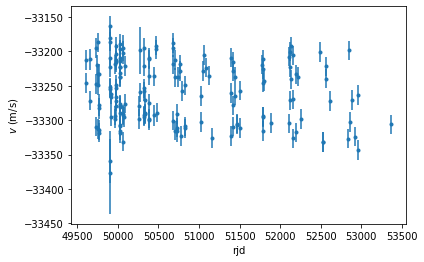

In [ ]:
rv_err = np.sqrt(rv_model.cov.A)
plt.figure()
for inst in instruments:
    kinst = rv_data['ins_name']==inst
    plt.errorbar(
        rv_data['rjd'][kinst],
        rv_data['rv'][kinst],
        yerr=rv_err[kinst],
        fmt='.', rasterized=True)
plt.xlabel('rjd')
plt.ylabel('$v$ (m/s)')
plt.show()
plt.close()

## Linear parameters

Plot activity indicator: fwhm_low


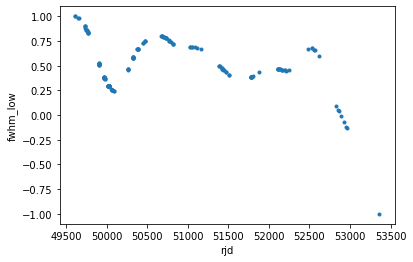

Fit linear parameters:
Parameter                        Value     Error       
lin.offset_inst_ELODIE       -33270.71  ±  2.50        
lin.fwhm_low                     23.96  ±  4.36        

loglikelihood = -1346.4375630823563


In [ ]:
# Add linear parameters
for inst in instruments:
    rv_model.add_lin(1.0*(rv_data['ins_name']==inst), f'offset_inst_{inst}')
for kpow in range(dpow):
    rv_model.add_lin(rv_model.t**(kpow+1), f'drift_pow{kpow+1}')
for kind, indic in enumerate(indicators):
    tmp = rv_data[indic].copy()
    if indic_kernel_smoother[kind] is not None:
        tau = 365.25*indic_filter_timescale_yr[kind]
        tmp_smooth = tools.smooth_timeseries(
            rv_data['rjd'],
            tmp,
            indic_kernel_smoother[kind], tau)
        if indic_filter_type[kind] == 'high':
            tmp -= tmp_smooth
        else:
            tmp = tmp_smooth
    tmpmx = tmp.max()
    tmpmn = tmp.min()
    tmp = 2.0*(tmp-tmpmn)/(tmpmx-tmpmn) - 1.0
    indic_name = indic
    if indic_filter_type[kind] is not None:
        indic_name += "_" + indic_filter_type[kind]
    rv_model.add_lin(tmp, indic_name)
    print('Plot activity indicator: {}'.format(indic_name))
    plt.figure()
    for inst in instruments:
        kinst = rv_data['ins_name']==inst
        plt.plot(rv_data['rjd'][kinst],
                 tmp[kinst],
                 '.', rasterized=True)
    plt.xlabel('rjd')
    plt.ylabel(indic_name)
    plt.show()
    plt.close()    
print("Fit linear parameters:")
rv_model.fit(method=fit_method, options=fit_options)
rv_model.show_param()
print('loglikelihood =', rv_model.loglike())

## Fit instruments jitter

In [ ]:
jitter_params = [f'cov.{key}.sig' for key in instjit]
if start_fit_jitter_at_step == 0:
    rv_model.fit_param += jitter_params
    rv_model.fit(method=fit_method,options=fit_options)
    rv_model.show_param()
    print('loglikelihood =', rv_model.loglike())

Parameter                        Value     Error       
lin.offset_inst_ELODIE       -33270.26  ±  7.64        
lin.fwhm_low                      22.7  ±  13.3        
cov.inst_jit_ELODIE.sig          42.57  ±  2.45        

loglikelihood = -857.5461949270618


## Search for planets iteratively

Plot residuals:


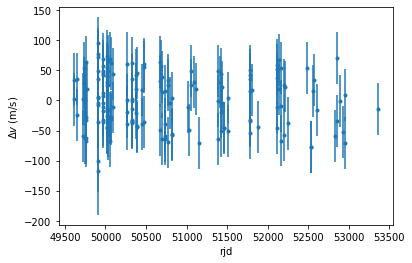

Periodogram of residuals:


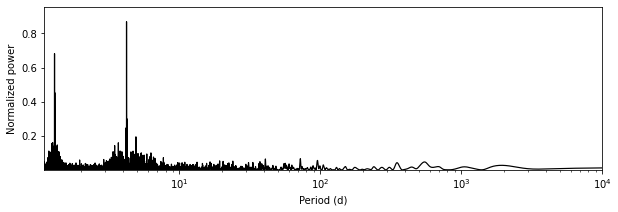

Highest periodogram peak:
P=4.230704017069059 d, power=0.868367044036876, FAP=2.551983193459755e-66

Fit all parameters:
Parameter                        Value     Error       
lin.offset_inst_ELODIE       -33266.53  ±  2.75        
lin.fwhm_low                     16.61  ±  4.80        
cov.inst_jit_ELODIE.sig         13.216  ±  0.961       
kep.0.P                      4.2307607  ±  0.0000869   
kep.0.la0 [deg]                 288.06  ±  8.49        
kep.0.K                          57.26  ±  1.70        
kep.0.ecosw                    -0.0124  ±  0.0278      
kep.0.esinw                    -0.0168  ±  0.0316      

loglikelihood = -685.8932342711257

Plot residuals:


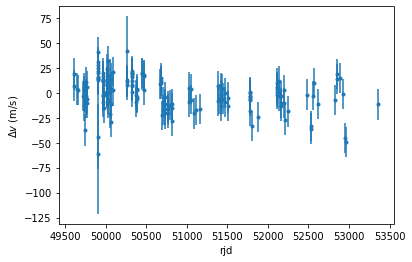

Periodogram of residuals:


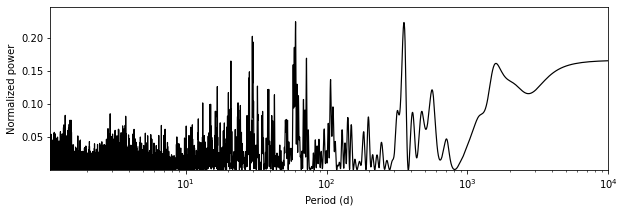

Highest periodogram peak:
P=60.3130125320837 d, power=0.22480065865981336, FAP=2.1509917195183803e-05

Fit all parameters:
Parameter                        Value     Error       
lin.offset_inst_ELODIE       -33273.19  ±  2.38        
lin.fwhm_low                     21.28  ±  3.98        
cov.inst_jit_ELODIE.sig          9.905  ±  0.858       
kep.0.P                      4.2307690  ±  0.0000712   
kep.0.la0 [deg]                 286.65  ±  6.99        
kep.0.K                          58.21  ±  1.42        
kep.0.ecosw                    -0.0042  ±  0.0228      
kep.0.esinw                    -0.0307  ±  0.0254      
kep.1.P                        60.2027  ±  0.0352      
kep.1.la0 [deg]                  336.4  ±  20.1        
kep.1.K                          12.71  ±  1.56        
kep.1.ecosw                     0.5046  ±  0.0945      
kep.1.esinw                      0.161  ±  0.137       

loglikelihood = -654.2109359743729

Plot residuals:


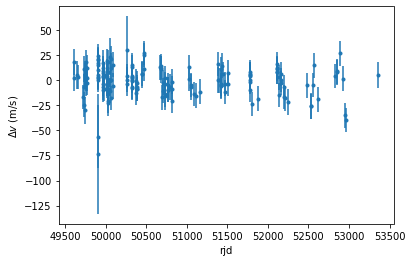

Periodogram of residuals:


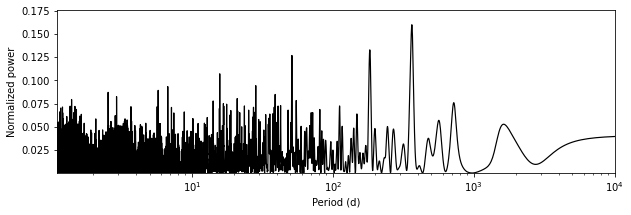

Highest periodogram peak:
P=363.0712930289582 d, power=0.16021289036049946, FAP=0.010463759389145455

Stopping here (non-significant detection)


In [ ]:
for _ in range(max_pla):
    # Plot residuals
    print('Plot residuals:')
    res = rv_model.residuals()
    rv_err = np.sqrt(rv_model.cov.A)
    plt.figure()
    for inst in instruments:
        kinst = rv_data['ins_name']==inst
        plt.errorbar(
            rv_data['rjd'][kinst],
            res[kinst],
            yerr=rv_err[kinst],
            fmt='.', rasterized=True)
    plt.xlabel('rjd')
    plt.ylabel('$\Delta v$ (m/s)')
    plt.show()
    plt.close()
    # Compute periodogram
    print('Periodogram of residuals:')
    nu, power = rv_model.periodogram(nu0, dnu, nfreq)
    P = 2 * np.pi / nu
    # Compute FAP
    kmax = np.argmax(power)
    faplvl = rv_model.fap(power[kmax], nu.max())
    # Plot periodogram
    plt.figure(figsize=(10, 3))
    plt.plot(P, power, 'k', lw=1.2, rasterized=True)
    plt.xlim(Pmin, Pmax)
    plt.ylim(power.min(), 1.1 * power.max())
    plt.xscale('log')
    plt.xlabel('Period (d)')
    plt.ylabel('Normalized power')
    plt.show()
    plt.close()
    # Show results
    print('Highest periodogram peak:')
    print('P={} d, power={}, FAP={}\n'.format(P[kmax], power[kmax], faplvl))
    if faplvl > fap_max:
        print('Stopping here (non-significant detection)')
        break    
    print('Fit all parameters:')
    # Add new planet
    rv_model.add_keplerian_from_period(P[kmax])
    rv_model.set_keplerian_param(f'{rv_model.nkep-1}', param=['P', 'la0', 'K', 'ecosw', 'esinw'])
    if not fit_ecc:
        rv_model.set_param(np.zeros(2), rv_model.fit_param[-2:])
        rv_model.fit_param = rv_model.fit_param[:-2]
    # Add jitter to fit_param if needed
    if rv_model.nkep == start_fit_jitter_at_step:
        rv_model.fit(method=fit_method, options=fit_options)
        rv_model.fit_param += jitter_params
    # Global fit of the model
    rv_model.fit(method=fit_method, options=fit_options)
    rv_model.show_param()
    print('loglikelihood = {}\n'.format(rv_model.loglike()))

## Phase folding

Planet 0 (4.231 d)


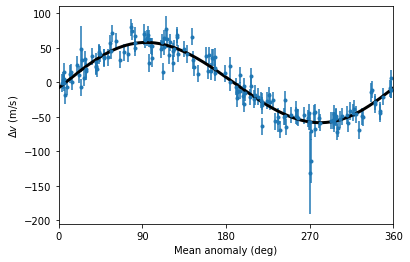

Planet 1 (60.203 d)


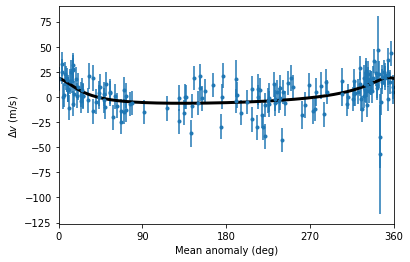

In [ ]:
res = rv_model.residuals()
rv_err = np.sqrt(rv_model.cov.A)
for name in rv_model.keplerian:
    kep = rv_model.keplerian[name]
    param = kep.get_param()
    rv_model.set_keplerian_param(name, param=['n', 'M0', 'K', 'ecosw', 'esinw'])
    n = rv_model.get_param(f'kep.{name}.n')
    M0 = rv_model.get_param(f'kep.{name}.M0')
    rv_model.set_keplerian_param(name, param=param)
    M = (M0 + n*rv_model.t)*180/np.pi % 360
    Mmod = np.linspace(0,360,1000)
    tmod = (Mmod*np.pi/180-M0)/n
    print(f'Planet {name} ({2*np.pi/n:.3f} d)')
    plt.figure()
    plt.xlim(0,360)
    plt.xticks([0,90,180,270,360])
    plt.plot(Mmod, kep.rv(tmod), 'k', lw=3, rasterized=True)
    for inst in instruments:
        kinst = rv_data['ins_name']==inst
        plt.errorbar(
            M[kinst],
            (res+kep.rv(rv_model.t))[kinst],
            yerr=rv_err[kinst],
            fmt='.', rasterized=True)
    plt.xlabel('Mean anomaly (deg)')
    plt.ylabel('$\Delta v$ (m/s)')
    plt.show()
    plt.close()

## Launch MCMC

In [ ]:
x_old = rv_model.get_param()
param = rv_model.fit_param
def lprior(x):
    lp = 0
    for par, val in zip(param, x):
        if '.sig' in par:
            lp += logprior.loguniform(val, np.log(1e-3), np.log(1e2))
        elif '.K' in par:
            lp += logprior.loguniform(val, np.log(0.1), np.log(1e5))
        elif '.P' in par:
            lp += logprior.loguniform(val, np.log(0.1), np.log(1e5))
        elif par.endswith('.e'):
            lp += logprior.beta(val, 0.867, 3.03)
        elif par.endswith('.ecosw'):
            parb = par.replace('.ecosw', '.esinw')
            valb = x[param.index(parb)]
            lp += logprior.modbeta(val, valb, 0.867, 3.03)
        # TODO : other parameters
    return(lp)
        
def lprob(x):
    try:
        lp = lprior(x)
        if not (lp > -np.inf):
            return (-np.inf)
        ll = rv_model.loglike(x, backup=False)
        if np.isnan(ll):
            return(-np.inf)
        return(lp + ll)
    except:
        return (-np.inf)

samples, diagnostics = sam(x_old, lprob, nsamples=nsamples)
rv_model.set_param(x_old)

Step 100000, acceptance rate (since last printing): 0.2710 


## Check convergence using ACF

maximum IAT: 196.24562322764774
effective number of samples: 382.17922400744584


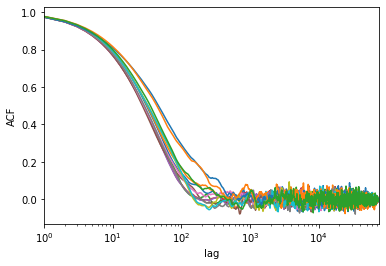

In [ ]:
R = acf.acf(samples[nsamples//4:])
tau = np.arange(R.shape[0])
plt.figure()
plt.plot(tau[1:], R[1:])
plt.xscale('log')
plt.xlim(1, tau[-1])
plt.xlabel('lag')
plt.ylabel('ACF')
iat = np.max(acf.iat(R=R))
print('maximum IAT:', iat)
print('effective number of samples:', R.shape[0]/iat)

## Corner plot

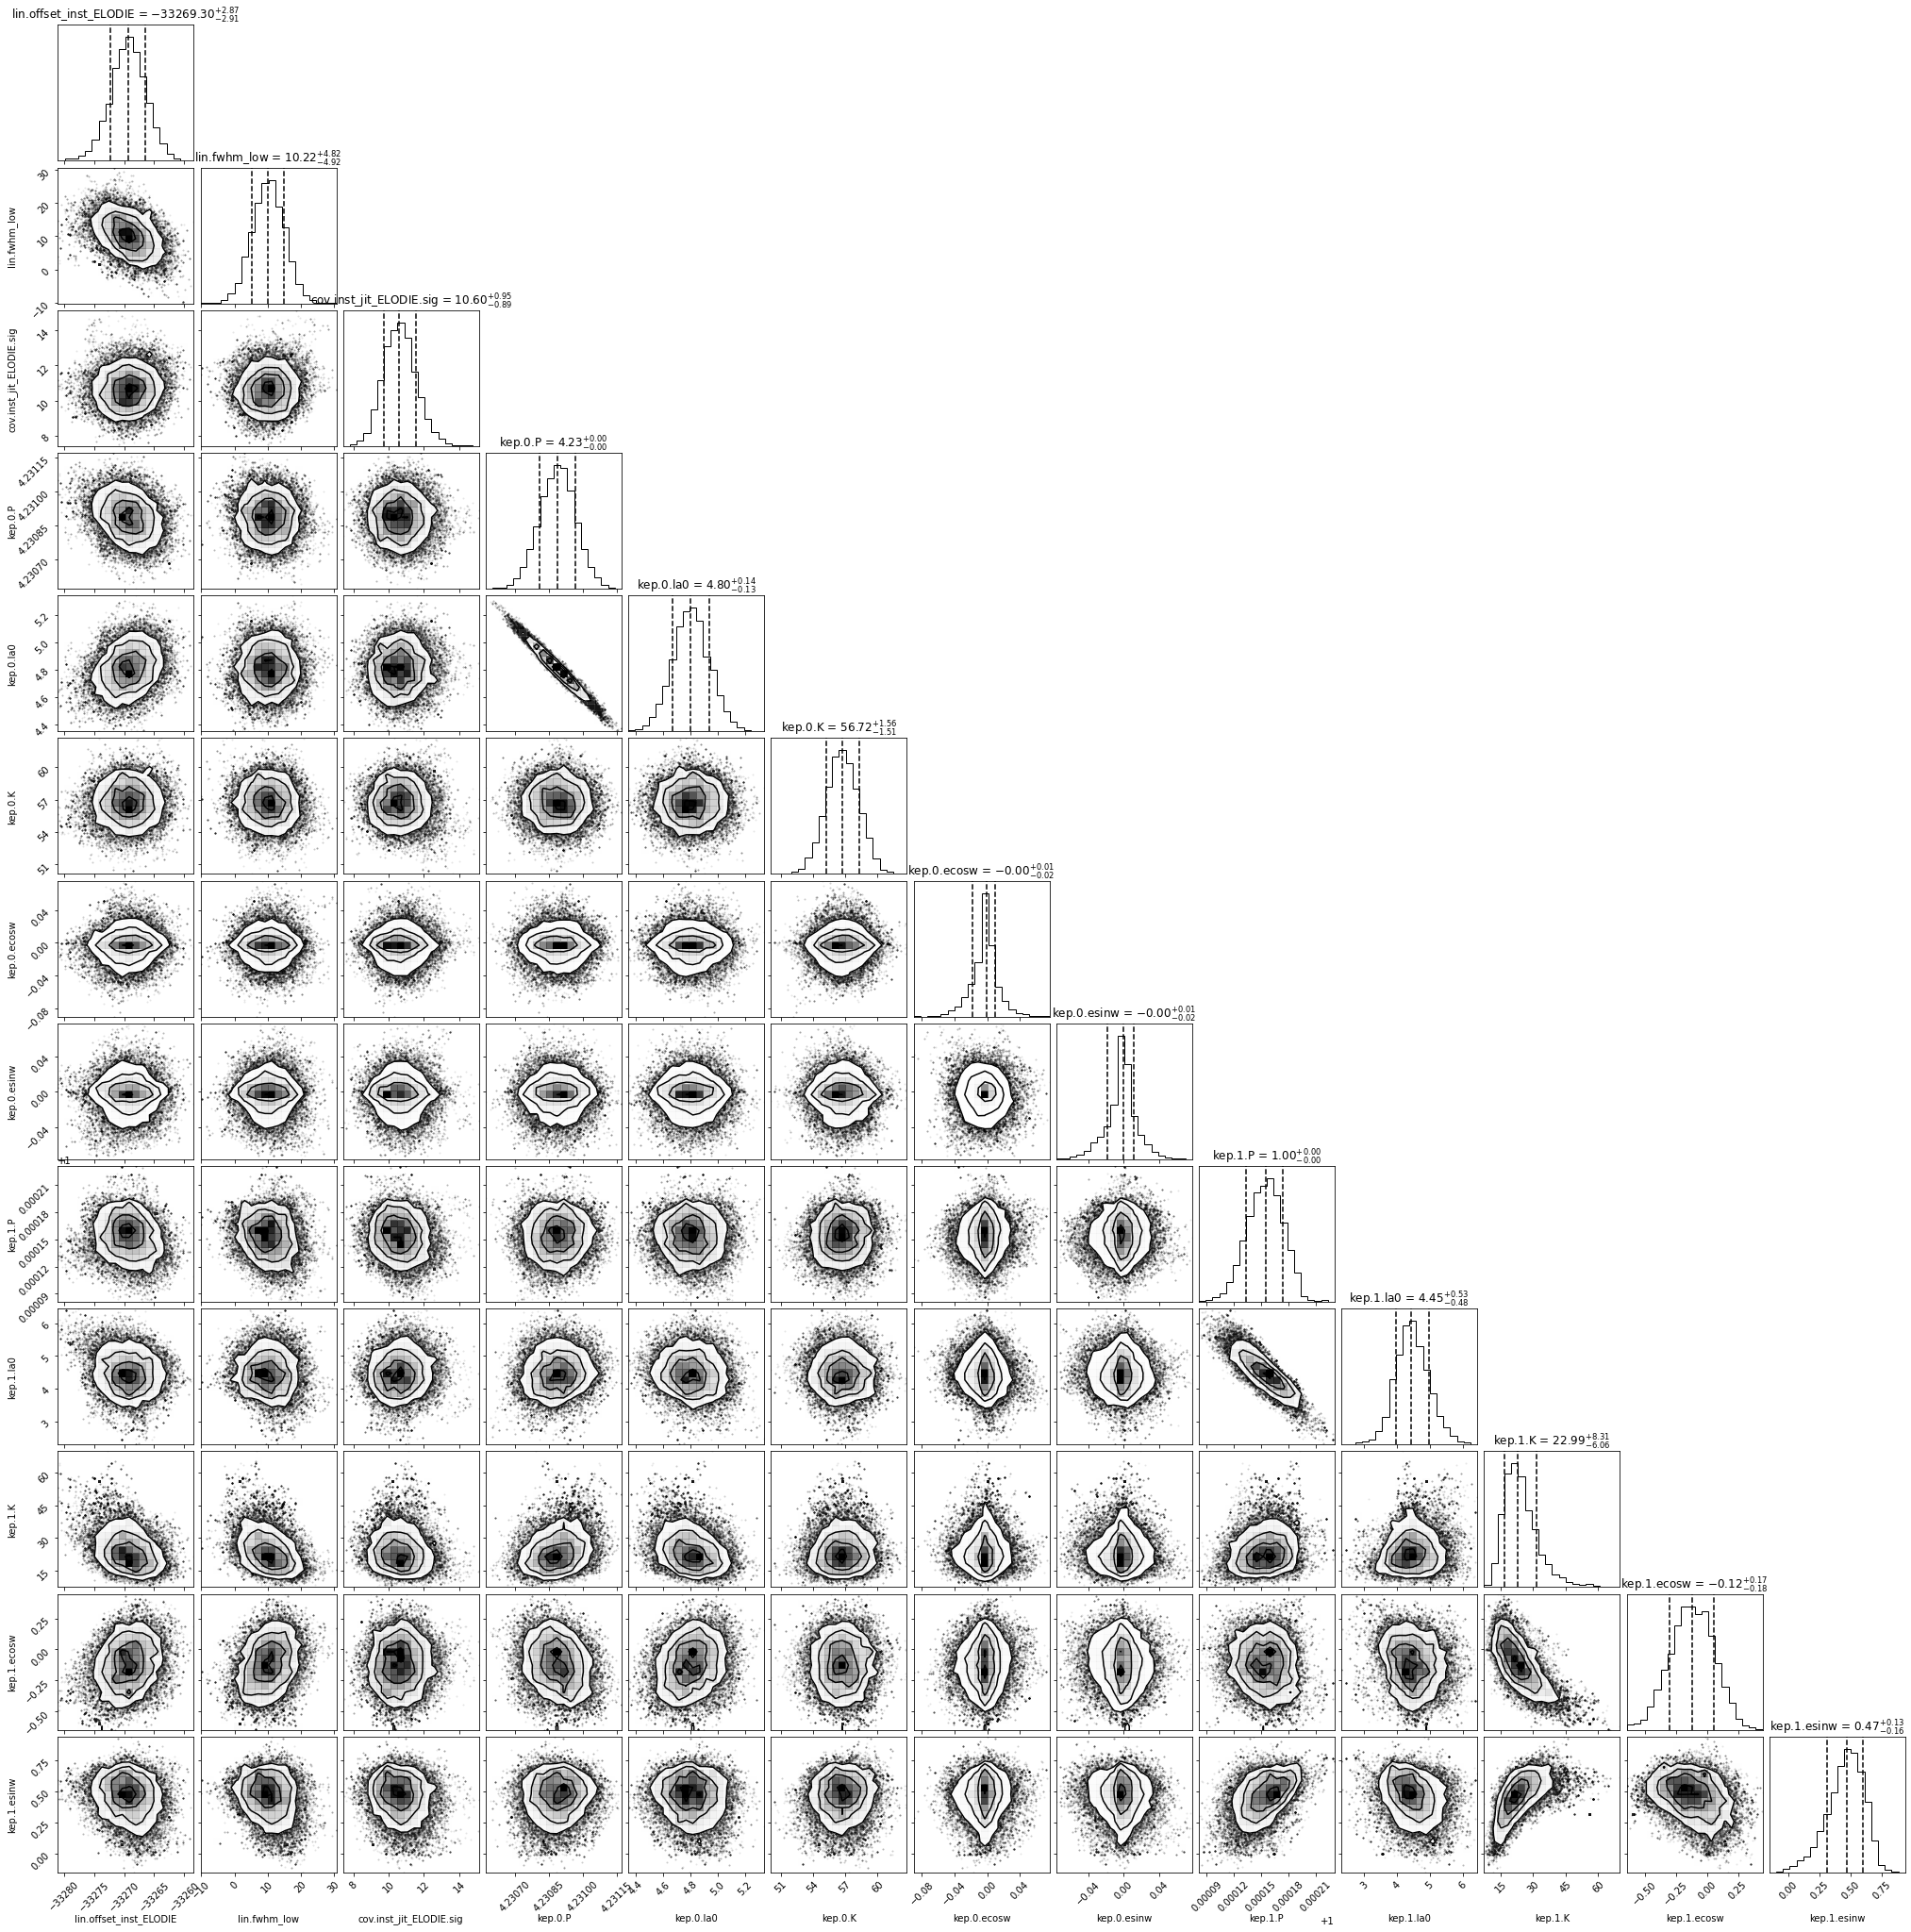

In [ ]:
corner.corner(
    samples[nsamples//4:],
    labels=rv_model.fit_param,
    quantiles=[0.159, 0.5, 0.841],
    show_titles=True)
plt.show()
plt.close()